In [ ]:
# Imports -- duplicates so when code is separated to different files, it can be run as a standalone script
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataloader import HVACDataset
from etl.canon import build_training_data


In [ ]:
from pathlib import Path
from etl.canon import build_training_data

# Path to the most recent diagnostic dataset
project_root = Path.cwd().parent
input_file = project_root / "output" / "2025-11-03" / "diagnostic_dataset_2025-11-03_20-59-20.json"

print(f"Building training data from: {input_file}\n")
stats = build_training_data(str(input_file))

print(f"✓ Created training data from {stats['total']} samples")
print(f"  - Train: {stats['train']} samples")
print(f"  - Val: {stats['val']} samples")
print(f"  - Test: {stats['test']} samples")
print(f"\n✓ Vocabulary sizes:")
print(f"  - Symptoms: {stats['vocab_sizes']['symptoms']}")
print(f"  - System types: {stats['vocab_sizes']['system_types']}")
print(f"  - Subtypes: {stats['vocab_sizes']['subtypes']}")
print(f"  - Brands: {stats['vocab_sizes']['brands']}")
print(f"  - Diagnostics: {stats['vocab_sizes']['diagnostics']}")
print(f"\n✓ Output files written to: {stats['output_dir']}/")
print("  - train.jsonl, val.jsonl, test.jsonl")
print("  - vocabs.json")


Building training data from: /Users/robertdoherty/Desktop/Playground/Motherboard/road_runner/output/2025-11-03/diagnostic_dataset_2025-11-03_20-59-20.json

✓ Created training data from 35 samples
  - Train: 24 samples
  - Val: 7 samples
  - Test: 4 samples

✓ Vocabulary sizes:
  - Symptoms: 93
  - Families: 11
  - Subtypes: 16
  - Brands: 12
  - Diagnostics: 12

✓ Output files written to: /Users/robertdoherty/Desktop/Playground/Motherboard/road_runner/diagnostic_prediction_model/etl/data/
  - train.jsonl, val.jsonl, test.jsonl
  - vocabs.json


## Optional: Run ETL Pipeline

Uncomment and run the cell below if you need to rebuild the training data from raw diagnostic dataset:

```python
# Example: Build training data from diagnostic dataset
# INPUT_FILE = "../../output/2025-11-03/diagnostic_dataset_2025-11-03_20-59-20.json"
# stats = build_training_data(INPUT_FILE, output_dir="data")
# 
# print(f"✓ Created training data from {stats['total']} samples")
# print(f"  - Train: {stats['train']} | Val: {stats['val']} | Test: {stats['test']}")
# print(f"  - Vocab sizes: {stats['vocab_sizes']}")
```


## Load Processed Data and Setup Dimensions


In [ ]:
import json
import torch
from torch.utils.data import DataLoader
from dataloader import HVACDataset

# Define paths (data files are in etl/data/)
VOCAB_PATH = "etl/data/vocabs.json"
TRAIN_PATH = "etl/data/train.jsonl"
VAL_PATH   = "etl/data/val.jsonl"
TEST_PATH  = "etl/data/test.jsonl"

# Load vocabs and calculate dimensions
v = json.load(open(VOCAB_PATH))

SYM_DIM = len(v["symptom2id"])
SYS_DIM = len(v["system_type2id"])
SUB_DIM = len(v["subtype2id"])
BR_DIM  = len(v["brand2id"])
INPUT_DIM = SYM_DIM + SYS_DIM + SUB_DIM + BR_DIM
NUM_CLASSES = len(v["diag2id"])

print(f"INPUT_DIM={INPUT_DIM}  NUM_CLASSES={NUM_CLASSES}")




INPUT_DIM=132  NUM_CLASSES=12


In [ ]:
# Create datasets
train_ds = HVACDataset(TRAIN_PATH, v)
val_ds   = HVACDataset(VAL_PATH, v)
test_ds  = HVACDataset(TEST_PATH, v)

print(f"rows: train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")

# Create dataloaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

rows: train=24 val=7 test=4


## Create PyTorch Datasets and DataLoaders


In [18]:
# Get a batch and inspect shapes
xb, yb = next(iter(train_dl))
xb.shape, yb.shape, xb.dtype, yb.dtype

(torch.Size([24, 132]), torch.Size([24, 12]), torch.float32, torch.float32)

## Inspect Batch Shape and Dtype


In [ ]:
class DiagnosticClassifier(nn.Module):
    """
    Wide + Deep over tabular vector x.
    Expects batch["x"] -> FloatTensor [B, INPUT_DIM]
    If training with labels:
      - soft labels: batch["y"] -> FloatTensor [B, C] (rows sum ~1)
      - hard labels: batch["y"] -> LongTensor [B] (class ids)
    """
    def __init__(self, input_dim, num_classes, hidden=(128,), drop=0.1, use_soft_labels=True):
        super().__init__()
        # Wide (linear)
        # This is a linear classifier head: it multiplies your input features by a weight matrix and adds a bias to produce class scores (logits). 
        # Think “quick memory” from each single feature directly to each diagnosis.
        self.wide = nn.Linear(input_dim, num_classes)

        # Deep (MLP ending in num_classes)
        layers, dims = [], [input_dim] + list(hidden) # dims is the width of each deep layer: start with input_dim, then the hidden sizes (e.g., [input_dim, 128]).
        for i in range(len(dims)-1): # The loop builds blocks: Linear → ReLU → Dropout from dims[i] to dims[i+1]
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(), nn.Dropout(drop)]
        layers += [nn.Linear(dims[-1], num_classes)]
        self.deep = nn.Sequential(*layers) # self.deep is the “combination brain” that learns feature interactions (e.g., symptom A and symptom B with brand C).

        # Loss choice -- criterion is the loss function (how wrong we are)
        self.use_soft_labels = use_soft_labels 
        self.criterion_ce = nn.CrossEntropyLoss() # CrossEntropy for hard labels (one class id per example).
        self.criterion_kl = nn.KLDivLoss(reduction="batchmean") # KLDiv for soft labels (a probability vector per example). Feed log-softmax(logits) against your probability targets

    def forward(self, batch):
        x = batch["x"].float()               # [B, INPUT_DIM]
        logits = self.wide(x) + self.deep(x) # [B, C]
        return logits

    # This is the loss function. It computes the loss between the model's logits and the true labels.
    def compute_loss(self, logits, y):
        if self.use_soft_labels:
            # y: soft probs [B, C]
            return F.kl_div(F.log_softmax(logits, dim=-1), y, reduction="batchmean") # Soft labels (y is probs [B,C] that sum to ~1): KLDiv with log_softmax(logits).
        else:
            # y: class ids [B]
            return self.criterion_ce(logits, y) # Hard labels (y is class ids [B]): CrossEntropy on logits directly.

    # We always use the combined logits (wide+deep). The only switch is which loss matches your label format:
    def step(self, batch):
        logits = self.forward(batch)
        loss = None
        if "y" in batch and batch["y"] is not None:
            loss = self.compute_loss(logits, batch["y"])
        return logits, loss

    @classmethod
    def from_vocabs(cls, vocabs: dict, **kw):
        input_dim = (len(vocabs["symptom2id"])
                     + len(vocabs["system_type2id"])
                     + len(vocabs["subtype2id"])
                     + len(vocabs["brand2id"]))
        num_classes = len(vocabs["diag2id"])
        return cls(input_dim=input_dim, num_classes=num_classes, **kw)


In [ ]:
# test model setup
model = DiagnosticClassifier.from_vocabs(v)
print(str(model)[:1000])

example_out = model({"x": xb})  # xb is your [B, 132] float tensor
example_out.shape, example_out.dtype ## shape defines number of examples and number of classes


DiagnosticClassifier(
  (wide): Linear(in_features=132, out_features=12, bias=True)
  (deep): Sequential(
    (0): Linear(in_features=132, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=12, bias=True)
  )
  (criterion_ce): CrossEntropyLoss()
  (criterion_kl): KLDivLoss()
)


(torch.Size([24, 12]), torch.float32)

In [27]:
## Creating training loop for model (soft labels)

num_epochs = 5
train_losses, val_losses = [], []

model = DiagnosticClassifier.from_vocabs(v, use_soft_labels=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss, n = 0.0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits, loss = model.step({"x": xb, "y": yb})
        loss.backward()
        optimizer.step()
        bs = xb.size(0)
        running_loss += loss.item() * bs
        n += bs
    train_loss = running_loss / max(1, n)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits, loss = model.step({"x": xb, "y": yb})
            bs = xb.size(0)
            running_loss += loss.item() * bs
            n += bs
    val_loss = running_loss / max(1, n)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  train={train_loss:.4f}  val={val_loss:.4f}")

print("Training complete")

Epoch 1/5  train=1.8940  val=1.9583
Epoch 2/5  train=1.8634  val=1.9493
Epoch 3/5  train=1.8442  val=1.9404
Epoch 4/5  train=1.8159  val=1.9316
Epoch 5/5  train=1.7897  val=1.9229
Training complete


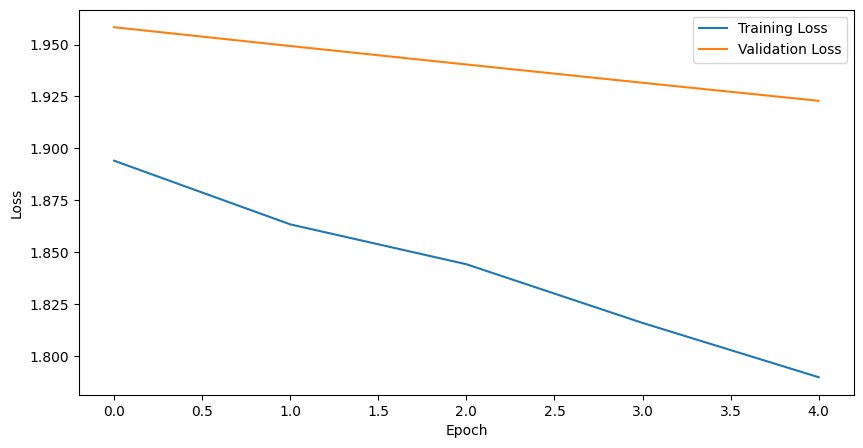

In [30]:
# Visualize training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save model


In [ ]:
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

checkpoint = {
    "state_dict": model.state_dict(),
    "vocabs": v,
    "config": {
        "input_dim": INPUT_DIM,
        "num_classes": NUM_CLASSES,
        "use_soft_labels": True,
    },
}

model_path = MODEL_DIR / "diagnostic_classifier.pt"
torch.save(checkpoint, model_path)
print(f"✓ Saved model checkpoint to {model_path}")



In [ ]:
# Reload saved checkpoint for inference/demo
checkpoint_path = MODEL_DIR / "diagnostic_classifier.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

inference_model = DiagnosticClassifier.from_vocabs(
    checkpoint["vocabs"], use_soft_labels=False
).to(device)
inference_model.load_state_dict(checkpoint["state_dict"])
inference_model.eval()

id2diag = {idx: diag for diag, idx in checkpoint["vocabs"]["diag2id"].items()}
class_names = [id2diag[i] for i in range(len(id2diag))]
print("✓ Reloaded diagnostic_classifier.pt for inference")



In [ ]:
## Evaluate the results
import torch
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np

# Predict using the model
def predict(model, xb, yb, device):
    model.eval()
    with torch.no_grad():
        
        logits = model({"x": xb})
        preds = torch.argmax(logits, dim=1)
    return preds



In [ ]:
import numpy as np
import textwrap
import matplotlib.pyplot as plt


def predict_probabilities(model, xb, device):
    model.eval()
    with torch.no_grad():
        xb = xb.unsqueeze(0).to(device)
        logits = model({"x": xb})
        probabilities = torch.softmax(logits, dim=1)
    return probabilities.squeeze(0).cpu().numpy()


def visualize_diagnostic_prediction(row, probabilities, class_names, top_k=5):
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

    axarr[0].axis("off")
    symptom_text = row.get("x_symptoms") or ", ".join(row.get("symptoms_canon", []))
    wrapped_post = textwrap.fill(row.get("x_post", ""), width=60)
    equip_info = row.get("equip", {})
    equipment_text = (
        equip_info.get("model_family_id")
        or equip_info.get("model_text")
        or equip_info.get("system_type")
        or "unknown"
    )
    axarr[0].text(
        0,
        1,
        (
            f"Post ID: {row.get('post_id')}\n"
            f"Symptoms: {symptom_text}\n"
            f"Equipment: {equipment_text}\n\n"
            f"Post:\n{wrapped_post}\n\n"
        ),
        va="top",
        fontsize=10,
    )

    top_idx = np.argsort(probabilities)[::-1][:top_k]
    top_probs = probabilities[top_idx]
    top_labels = [class_names[i] for i in top_idx]

    axarr[1].barh(top_labels[::-1], top_probs[::-1], color="steelblue")
    axarr[1].set_xlabel("Probability")
    axarr[1].set_xlim(0, 1)
    axarr[1].set_title("Diagnostic Predictions")

    plt.tight_layout()
    plt.show()


if len(test_ds) == 0:
    raise ValueError("Test dataset is empty — run ETL first to generate test.jsonl")

num_examples = min(3, len(test_ds))
sample_indices = np.random.choice(len(test_ds), num_examples, replace=False)

for idx in sample_indices:
    xb, _ = test_ds[idx]
    probabilities = predict_probabilities(inference_model, xb, device)
    row = test_ds.rows[idx]
    visualize_diagnostic_prediction(row, probabilities, class_names)

